# Perkeso Data Exploration

### Imports

In [12]:
# Imports
random_seed = 42
import os
import pandas as pd
import numpy as np
import glob
#np.random.seed(seed = seed) 
#import random
#random.seed = seed
#import os
#os.environ['PYTHONHASHSEED'] = '0'
#from utils.utilities import *
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')
#from scipy import stats
import tensorflow as tf
from scipy import stats
from datetime import datetime

import augment
import preprocess

In [5]:
#to know how many times we need to generate augmented data for each gesture
def aug_times(mov):
    a = {'0': 4, '1': 5,'2': 1, '3': 2, '4': 5, '5': 5, '6': 5, '7': 7, '8': 7}
    return a[mov]

## Load data
patientid_date_label_repetitionNumber_correction_position.txt

In [6]:
def load_move_data(mov):
    print('Loading move:', mov)
    # patientid_date_label_repetitionNumber_correction_position.txt
    #moves = ['0']#,'1','2','3','4','5','6','7','8']
    labels = ['1','2']
    subjects = ['104', '209', '205', '213', '303', '204', '201', '210', '211', '206', '103', '203', '305', '202', '217', '105',
     '107',  '304', '302', '212', '102', '306', '208', '214', '307', '106', '216', '215', '218', '207', '301', '101']
    #dates = ['19', '14', '12', '13', '07', '18']
    #position = ['sit', 'stand','chair','wheelchair','Stand-frame']
    data = pd.DataFrame()
    #for mov in moves:
    #print('Move: ',mov)
    for label in labels:
        #count = 0
        #print('Label: ',label)
        for subj in subjects:
            #print('Subj: ',subj)
            for file_name in glob.glob('/home/noureddin/Perkeso-Simplified/'+subj+'_*_'+mov+'_*_'+label+'_*.txt'):
                #count += 1
                tmp_df = pd.read_csv(file_name,header=None)
                if len(tmp_df) >= 28:
                    tmp_ = pd.DataFrame()#for augmentation
                    if label == '2':
                        #now augment data                        
                        augment_times = aug_times(mov)
                        for i in range(0,augment_times):                
                            tdata = tmp_df.values
                            #dd = DA_TimeWarp(DA_Permutation(DA_Rotation(data)))
                            dd = augment.DA_TimeWarp3(augment.DA_Rotation((tdata)))
                            #make sure the # of rows is 28
                            dd = preprocess.normalize_move(pd.DataFrame(dd), 28, mean=False)
                            #transform values into specific range
                            dd = preprocess.normalize_df(dd) # e.g. all cols in range [0,1]
                            #mean centre the df
                            dd = preprocess.mean_centre_data(dd)                
                            tmp_ = tmp_.append(dd,ignore_index=True)
                
                    #make sure the # of rows is 28
                    tmp_df = preprocess.normalize_move(tmp_df, 28, mean=False)
                    #transform values into specific range
                    tmp_df = preprocess.normalize_df(tmp_df) # e.g. all cols in range [0,1] 
                    #mean centre the df
                    tmp_df = preprocess.mean_centre_data(tmp_df)
                    tmp_df['Original'] = 1 
                    if len(tmp_) > 0:
                        tmp_['Original']   = 0
                        tmp_df = tmp_df.append(tmp_,ignore_index=True)
                
                    tmp_df.columns = ['f_'+str(i) for i in range(tmp_df.shape[1])]
                    tmp_df.rename(columns={'f_75':'Original'}, inplace=True)
                    
                    tmp_df['Subject'] = subj
                    tmp_df['Class'] = 1 if label == '1' else 0
                    data = data.append(tmp_df,ignore_index=True)
                    #print(data.shape)   
    return data

In [7]:
#data = load_move_data('6')

In [8]:
#print(data[data['Class'] == 1].shape)
#print(data[data['Class'] == 0].shape)
#data.tail()

### Hyperparameters

In [15]:
# Imports
#import tensorflow as tf

input_width = 28
seq_len = input_width          # Number of steps

lstm_size = 225     # 3 times the amount of channels
lstm_layers = 3        # Number of layers
batch_size = 2       # Batch size

learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 50

# Fixed
n_classes = 2

num_features = 75
n_channels = num_features

## Train the Network
* Placeholders
* Build Convolutional Layers (Note: Should we use a different activation? Like tf.nn.tanh?)
* Then flatten and pass to the classifier

In [22]:
moves = ['0','1','2', '3','4','5','6','7','8']
overall_results = {}
start_time = datetime.now()
for mov in moves:
    appended_data = load_move_data(mov)
    #subjects = get_subjects(mov)
    subj_results = {}
    
    for test_subj in subjects:
        print('Doing subj:', test_subj)
        subj_start_time = datetime.now()
        ### Split data into Train and Test
        #test_subj           = 's06'
        test_subject        = appended_data[appended_data['Subject'] == test_subj]
        # test only on original data .. don't include augment data
        test_subject = test_subject[test_subject['Original'] == 1]
        
        train_subjects         = appended_data[appended_data['Subject'] != test_subj]
        
        X_train, labels_train  = preprocess.segment_signal(train_subjects, input_width, num_features)
        X_test, labels_test    = preprocess.segment_signal(test_subject, input_width, num_features)
        
        # Normalize?
        #X_train, mean_   = zero_mean(X_train,0) 
        ##X_train, mean_, std_    = standardize(X_train,0,0)
        # replace NaNs with 0's
        X_train[np.isnan(X_train)] = 0

        # Normalize?
        #X_test, _        = zero_mean(X_test,mean_, train=False)
        ##X_test, _, _            = standardize(X_test,mean_, std_, train=False)
        # replace NaNs with 0's
        X_test[np.isnan(X_test)] = 0
        
        
        
        #X_train, mean, std    = normalize(X_train)
        #X_test                = normalize(X_test)

        #### One-hot encoding for labels:
        # Notice that we add two extra elements 0,1
        # Because sometimes we only have correct or incorrect
        # move for some subjects and this makes one hot encoding not possible
        # one_hot and then drop the elements we added    
        y_tr   = preprocess.one_hot(np.append(labels_train, [0,1]))[:-2]
        y_test = preprocess.one_hot(np.append(labels_test, [0,1]))[:-2]
        #we make sure there's at least 2 test episodes for this test subject
        #otherwise no point training the LSTM
        if len(y_test) > 1:
            ### Construct the graph
            tf.reset_default_graph()
            graph = tf.Graph()
            # Construct placeholders
            with graph.as_default(), tf.device('/gpu:0'):
                #Placeholders
                inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
                labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
                keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
                learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')
                # Construct the LSTM inputs and LSTM cells
                lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
                lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)

                # To cells
                lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?

                # Open up the tensor into a list of seq_len pieces
                lstm_in = tf.split(lstm_in, seq_len, 0)

                # Add LSTM layers
                lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
                drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
                cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
                initial_state = cell.zero_state(batch_size, tf.float32)

                ## Define forward pass, cost function and optimizer:
                outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                         initial_state = initial_state)

                # We only need the last output tensor to pass into a classifier
                logits = tf.layers.dense(outputs[-1], n_classes, name='logits')

                # Cost function and optimizer
                cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
                #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping

                # Grad clipping
                train_op = tf.train.AdamOptimizer(learning_rate_)

                gradients = train_op.compute_gradients(cost)
                capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
                optimizer = train_op.apply_gradients(capped_gradients)

                # Accuracy
                correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

            with tf.Session(graph=graph) as sess:
                sess.run(tf.global_variables_initializer())
                #iteration = 1

                for e in range(epochs):
                    # Initialize 
                    state = sess.run(initial_state)
                    #print("Epoch: {}/{}".format(e, epochs))
                    #iteration = 1
                    # Loop over batches
                    #for x,y in get_random_batches(X_tr, y_tr, num_batches,batch_size):
                    #for x,y in get_batches(X_tr, y_tr, batch_size):
                    for x,y in preprocess.get_batches(X_train, y_tr, batch_size, shuffle=True):

                        # Feed dictionary
                        feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                                initial_state : state, learning_rate_ : learning_rate}

                        loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                                         feed_dict = feed)

                test_acc = []


                # Restore
                #saver.restore(sess, tf.train.latest_checkpoint(save_dir))
                test_state = sess.run(cell.zero_state(batch_size, tf.float32))
                print(X_test.shape, y_test.shape)
                for x_t, y_t in preprocess.get_batches(X_test, y_test, batch_size, shuffle=False):
                    feed = {inputs_: x_t,
                            labels_: y_t,
                            keep_prob_: 1,
                            initial_state: test_state}

                    batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
                    test_acc.append(batch_acc)
                print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
                subj_results[test_subj] = np.mean(test_acc)
            print("Subj:", test_subj,"took: ", datetime.now() - subj_start_time)
            #shutil.rmtree(save_dir, ignore_errors=True)
    overall_results[mov] = subj_results
    print("====================================")
print("Overall took: ", datetime.now() - start_time)

Loading move: 3
Doing subj: 104
(6, 28, 75) (6, 2)
Test accuracy: 1.000000
Subj: 104 took:  0:04:18.710293
Doing subj: 209
(5, 28, 75) (5, 2)
Test accuracy: 1.000000
Subj: 209 took:  0:04:20.224329
Doing subj: 205
Doing subj: 213
(7, 28, 75) (7, 2)
Test accuracy: 0.166667
Subj: 213 took:  0:04:11.790668
Doing subj: 303
(12, 28, 75) (12, 2)
Test accuracy: 1.000000
Subj: 303 took:  0:04:16.345867
Doing subj: 204
(58, 28, 75) (58, 2)
Test accuracy: 0.879310
Subj: 204 took:  0:03:12.666906
Doing subj: 201
(17, 28, 75) (17, 2)
Test accuracy: 0.875000
Subj: 201 took:  0:03:58.859364
Doing subj: 210
(5, 28, 75) (5, 2)
Test accuracy: 0.750000
Subj: 210 took:  0:04:20.141209
Doing subj: 211
(5, 28, 75) (5, 2)
Test accuracy: 1.000000
Subj: 211 took:  0:04:19.916880
Doing subj: 206
(17, 28, 75) (17, 2)
Test accuracy: 0.875000
Subj: 206 took:  0:03:57.605159
Doing subj: 103
(24, 28, 75) (24, 2)
Test accuracy: 1.000000
Subj: 103 took:  0:04:10.792570
Doing subj: 203
(4, 28, 75) (4, 2)
Test accuracy

(24, 28, 75) (24, 2)
Test accuracy: 1.000000
Subj: 103 took:  0:03:40.099122
Doing subj: 203
Doing subj: 305
(12, 28, 75) (12, 2)
Test accuracy: 1.000000
Subj: 305 took:  0:03:45.458702
Doing subj: 202
Doing subj: 217
(6, 28, 75) (6, 2)
Test accuracy: 0.833333
Subj: 217 took:  0:03:48.173097
Doing subj: 105
(16, 28, 75) (16, 2)
Test accuracy: 0.750000
Subj: 105 took:  0:03:43.556393
Doing subj: 107
Doing subj: 304
(6, 28, 75) (6, 2)
Test accuracy: 1.000000
Subj: 304 took:  0:03:48.204560
Doing subj: 302
(12, 28, 75) (12, 2)
Test accuracy: 1.000000
Subj: 302 took:  0:03:45.299959
Doing subj: 212
(5, 28, 75) (5, 2)
Test accuracy: 0.750000
Subj: 212 took:  0:03:39.235740
Doing subj: 102
(24, 28, 75) (24, 2)
Test accuracy: 1.000000
Subj: 102 took:  0:03:39.699397
Doing subj: 306
(13, 28, 75) (13, 2)
Test accuracy: 1.000000
Subj: 306 took:  0:03:45.542463
Doing subj: 208
Doing subj: 214
(4, 28, 75) (4, 2)
Test accuracy: 0.500000
Subj: 214 took:  0:03:49.139737
Doing subj: 307
(12, 28, 75) (

In [ ]:
# save results in JSON fi

In [49]:
import json
with open('NIPS19-Perkeso-LSTM-Results.json', 'w') as outfile:
    json.dump(str(overall_results), outfile)


In [13]:
import json

with open('NIPS19-Perkeso-LSTM-Results.json') as json_file:  
    overall_results = json.loads(json_file.read())

In [16]:
overall_results = {'0': {'104': 1.0, '209': 0.8333333, '205': 1.0, '213': 1.0, '303': 1.0, '204': 1.0, '201': 0.6666667, '211': 0.75, '206': 1.0, '103': 0.9583333, '305': 1.0, '217': 0.75, '105': 1.0, '304': 1.0, '302': 1.0, '212': 0.6666667, '102': 1.0, '306': 0.75, '214': 0.6666667, '307': 0.9, '216': 0.8333333, '215': 0.6666667, '207': 1.0, '301': 1.0, '101': 0.875}, '1': {'104': 1.0, '209': 0.6666667, '205': 0.75, '213': 0.5, '303': 1.0, '204': 0.8333333, '201': 0.85714287, '210': 0.8333333, '211': 1.0, '206': 0.75, '103': 1.0, '305': 0.9, '217': 0.8333333, '105': 1.0, '304': 0.33333334, '302': 0.9166667, '212': 0.8333333, '102': 1.0, '306': 0.9166667, '214': 0.5, '307': 0.9166667, '216': 0.33333334, '215': 0.0, '207': 0.5714286, '301': 1.0, '101': 1.0}, '2': {'104': 1.0, '209': 0.41666666, '213': 1.0, '303': 1.0, '204': 0.7586207, '201': 0.9130435, '210': 0.0, '211': 1.0, '206': 0.875, '103': 1.0, '203': 0.85714287, '305': 1.0, '217': 1.0, '105': 1.0, '304': 1.0, '302': 0.9166667, '212': 0.8333333, '102': 0.9583333, '306': 1.0, '214': 0.6666667, '307': 0.9166667, '216': 0.75, '215': 0.8, '301': 0.9166667, '101': 1.0}, '3': {'104': 1.0, '209': 1.0, '213': 0.16666667, '303': 1.0, '204': 0.87931037, '201': 0.875, '210': 0.75, '211': 1.0, '206': 0.875, '103': 1.0, '203': 0.5, '305': 1.0, '217': 1.0, '105': 1.0, '304': 1.0, '302': 1.0, '212': 0.8333333, '102': 1.0, '306': 1.0, '214': 1.0, '307': 1.0, '216': 1.0, '215': 0.8333333, '207': 0.75, '301': 1.0, '101': 0.8333333}, '4': {'104': 0.6666667, '213': 1.0, '303': 0.75, '204': 0.5, '201': 1.0, '210': 0.75, '211': 1.0, '206': 0.41666666, '103': 0.875, '305': 0.8333333, '202': 0.41666666, '217': 1.0, '105': 1.0, '304': 0.8333333, '302': 1.0, '212': 0.6666667, '102': 1.0, '306': 1.0, '214': 1.0, '307': 1.0, '216': 1.0, '215': 0.6, '301': 1.0, '101': 0.8333333}, '5': {'104': 1.0, '209': 1.0, '213': 0.5, '303': 0.9166667, '204': 0.6666667, '201': 1.0, '210': 0.6666667, '211': 1.0, '206': 0.5, '103': 1.0, '203': 0.6666667, '305': 0.9166667, '217': 1.0, '105': 0.8333333, '304': 1.0, '302': 1.0, '212': 0.6666667, '102': 1.0, '306': 1.0, '214': 0.75, '307': 1.0, '216': 1.0, '215': 0.875, '301': 0.9166667, '101': 1.0}, '6': {'104': 1.0, '209': 1.0, '213': 1.0, '303': 1.0, '204': 0.8333333, '201': 0.6666667, '210': 0.0, '211': 1.0, '206': 0.85714287, '103': 1.0, '305': 1.0, '217': 0.8333333, '105': 0.75, '304': 1.0, '302': 1.0, '212': 0.75, '102': 1.0, '306': 1.0, '214': 0.5, '307': 0.9166667, '216': 0.8333333, '215': 1.0, '207': 0.95, '301': 0.9166667, '101': 1.0}, '7': {'104': 0.8333333, '209': 0.33333334, '213': 1.0, '303': 0.9166667, '204': 1.0, '211': 1.0, '206': 0.75, '103': 1.0, '305': 1.0, '202': 1.0, '217': 1.0, '105': 0.9166667, '304': 0.8333333, '302': 0.8333333, '212': 0.5, '102': 0.9583333, '306': 0.9166667, '214': 0.8333333, '307': 1.0, '216': 0.5, '215': 1.0, '207': 0.5, '301': 1.0, '101': 1.0}, '8': {'104': 1.0, '209': 0.75, '213': 0.33333334, '303': 0.9166667, '204': 0.9166667, '211': 1.0, '206': 0.6, '103': 0.9583333, '305': 0.9, '202': 0.8695652, '217': 1.0, '105': 1.0, '304': 0.8333333, '302': 1.0, '212': 0.6666667, '102': 0.9583333, '306': 1.0, '214': 0.33333334, '307': 0.9166667, '216': 1.0, '215': 0.8, '207': 0.16666667, '301': 1.0, '101': 1.0}}

In [17]:
for k,v in overall_results.items():
    vals = (list(v.values()))
    avg = sum(vals) / len(vals)
    print(k,avg)

0 0.8926666679999999
1 0.7786630057692308
2 0.8631522852000001
3 0.895999113076923
4 0.8392361091666668
5 0.8750000080000001
6 0.8722857148
7 0.8593749974999999
8 0.8299818854166667


In [45]:
overall_results

{'0': {'104': 1.0,
  '209': 0.8333333,
  '205': 1.0,
  '213': 1.0,
  '303': 1.0,
  '204': 1.0,
  '201': 0.6666667,
  '211': 0.75,
  '206': 1.0,
  '103': 0.9583333,
  '305': 1.0,
  '217': 0.75,
  '105': 1.0,
  '304': 1.0,
  '302': 1.0,
  '212': 0.6666667,
  '102': 1.0,
  '306': 0.75,
  '214': 0.6666667,
  '307': 0.9,
  '216': 0.8333333,
  '215': 0.6666667,
  '207': 1.0,
  '301': 1.0,
  '101': 0.875},
 '1': {'104': 1.0,
  '209': 0.6666667,
  '205': 0.75,
  '213': 0.5,
  '303': 1.0,
  '204': 0.8333333,
  '201': 0.85714287,
  '210': 0.8333333,
  '211': 1.0,
  '206': 0.75,
  '103': 1.0,
  '305': 0.9,
  '217': 0.8333333,
  '105': 1.0,
  '304': 0.33333334,
  '302': 0.9166667,
  '212': 0.8333333,
  '102': 1.0,
  '306': 0.9166667,
  '214': 0.5,
  '307': 0.9166667,
  '216': 0.33333334,
  '215': 0.0,
  '207': 0.5714286,
  '301': 1.0,
  '101': 1.0},
 '2': {'104': 1.0,
  '209': 0.41666666,
  '213': 1.0,
  '303': 1.0,
  '204': 0.7586207,
  '201': 0.9130435,
  '210': 0.0,
  '211': 1.0,
  '206': 0.875

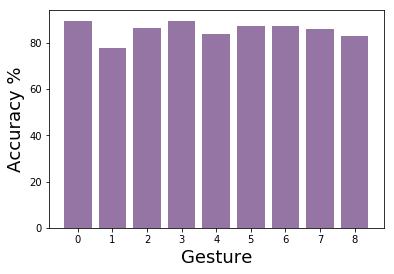

In [22]:
D = {}

for k,v in overall_results.items():
    vals = (list(v.values()))
    avg = sum(vals) / len(vals)
    D[k] = avg*100
    
# Create bars
barWidth = 1
bars1 = list(D.values())

# The X position of bars
r1 = range(len(D))

plt.bar(r1, bars1, align='center', color = (0.3,0.1,0.4,0.6))

plt.xticks(range(len(D)), list(D.keys()))


plt.xlabel('Gesture',  fontsize=18)
plt.ylabel('Accuracy %', fontsize=18)
plt.show()

In [31]:
np.mean(list(D.values()))

85.62621985477209

In [25]:
overall_results['0']

{'104': 1.0,
 '209': 0.8333333,
 '205': 1.0,
 '213': 1.0,
 '303': 1.0,
 '204': 1.0,
 '201': 0.6666667,
 '211': 0.75,
 '206': 1.0,
 '103': 0.9583333,
 '305': 1.0,
 '217': 0.75,
 '105': 1.0,
 '304': 1.0,
 '302': 1.0,
 '212': 0.6666667,
 '102': 1.0,
 '306': 0.75,
 '214': 0.6666667,
 '307': 0.9,
 '216': 0.8333333,
 '215': 0.6666667,
 '207': 1.0,
 '301': 1.0,
 '101': 0.875}

In [30]:
moves = ['0','1','2','3','4','5','6','7','8']
for m in moves:
    print(m)
    print(list(overall_results[m].values()).count(1))
    print(min(overall_results[m].values()), max(overall_results[m].values()))
    print('----')

0
13
0.6666667 1.0
----
1
8
0.0 1.0
----
2
11
0.0 1.0
----
3
16
0.16666667 1.0
----
4
12
0.41666666 1.0
----
5
13
0.5 1.0
----
6
13
0.0 1.0
----
7
11
0.33333334 1.0
----
8
9
0.16666667 1.0
----
